In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve

This project focuses on the use of machine learning (ML) methods in order to successfully train a model using customer information for making predictions on whether a customer will make a fixed term savings deposit (FTSD) or not. The full dataset (bank marketing data from the UCI Machine Learning Repository).

1. **Data Preprocessing** - EDA and Preparation for Modelling

In [2]:
bank_data = pd.read_csv("bank-additional-full.csv", sep=";")  # Reading in the dataset and splitting by ";"
bank_data = bank_data.drop(columns=["duration"]) # Dropping duration as suggested in the txt file

As discussed in bank-additional-names.txt, the column "duration" highly affects the output target and "should be discarded if the intention is to have a realistic predictive model", which is the goal for this project.

In [3]:
bank_data.head() # Displaying first few columns to develop initial understandings of dataset

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Just via an initial inspection of the dataset we can observe that there are no unique identifiers, but we can run a quick test to check. If we identify any columns which are unique identifiers then we should drop them as they will prove no use in improving our models.

In [4]:
print(f"Columns which act as unique identifiers: {[col for col in bank_data.columns if bank_data[col].nunique() == len(bank_data)]}") # Checking for unique identifiers

Columns which act as unique identifiers: []


In [5]:
print(bank_data.info()) # Checking dataset shape, types of columns and for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

We obtain an overview of the dataset shape here: 20 columns, 41188 rows. We observe no missing values using the built-in info method. However, we should check for "unknown" values as described in the dataset description file.

In [6]:
print(bank_data.isin(["unknown"]).sum()) # Searching for missing values as described in bank-additional-names.txt

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64


It is notable that "unknown" values are not present in any numerical columns, only categorical. This is relevant to which imputation techniques may be experimented with.

Unknown data may be used for prediction in this case. Clearly, there are some columns which unknown data is prevalent in. In regard to using this model for a real life client, there is also a realistic chance that they could have unknown data in some of these categories. It could be useful to train our model with unknown data preserved so that we can apply it more efficiently to real world scenarios. This is especially relevant with some of these categories where people may prefer not to answer them (perhaps due to privacy concerns), so data isn't recorded for certain areas.

We could use one-hot encoding or ordinal encoding while still preserving our "unknown" data. The main thing is that we are missing no instances of the outcome variable "y", which will allow us to make predictions even if a client has some unknown data.

We will experiment with both ordinal and one-hot encoding in order to see which is more suitable for the model:
1. Ordinal encoding for columns which have natural ordering alongside one-hot encoding for columns without natural order
2. One-hot encoding all columns

We will first explore our dataset more to gain an understanding of how columns should be encoded or if there are any interesting relationships between categories.

In [7]:
# Defining categorical attributes
categorical_attributes  = ["education", "default", "housing", "loan", "month", "day_of_week", "poutcome", "job", "marital", "contact"]
# Defining numerical attributes
numerical_attributes  = ["age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

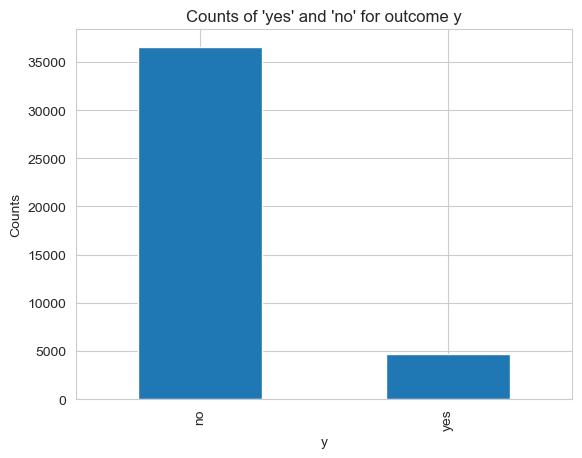

In [8]:
# Exploring outcome column y
bank_data["y"].value_counts().plot(kind="bar", title="Counts of 'yes' and 'no' for outcome y")
plt.ylabel("Counts")
plt.show()

Clearly from our plot of y we can see that our dataset is extremely imbalanced. This is something we should keep in mind when deciding how to proceed.

In [9]:
ratio_unknown_yes = bank_data[bank_data["y"] == "yes"].isin(["unknown"]).any(axis=1).mean()
print(f"Ratio of rows with 'unknown' when y is 'yes': {ratio_unknown_yes}")

Ratio of rows with 'unknown' when y is 'yes': 0.16831896551724138


If we just remove all rows containing unknown data we will likely struggle to train our model to predict accurately when the outcome should be "yes" (16.8% of data with outcome "yes" contains a row with some form of unknown data, and we already have small amounts of data of this type).

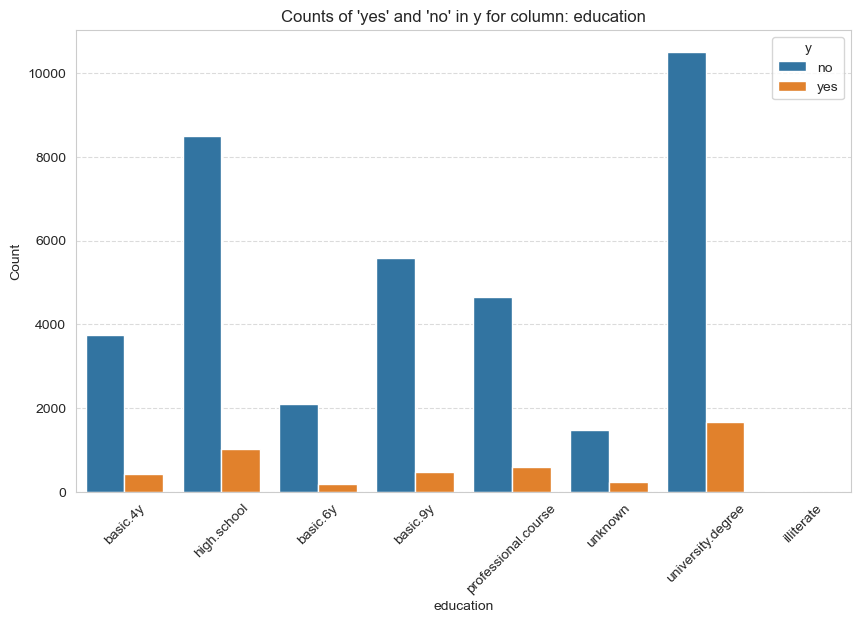

Ratio of 'yes' in education for basic.4y: 0.1024904214559387
Ratio of 'yes' in education for high.school: 0.10835522858644246
Ratio of 'yes' in education for basic.6y: 0.08202443280977312
Ratio of 'yes' in education for basic.9y: 0.0782464846980976
Ratio of 'yes' in education for professional.course: 0.11348464619492657
Ratio of 'yes' in education for unknown: 0.14500288850375506
Ratio of 'yes' in education for university.degree: 0.13724523339907954
Ratio of 'yes' in education for illiterate: 0.2222222222222222


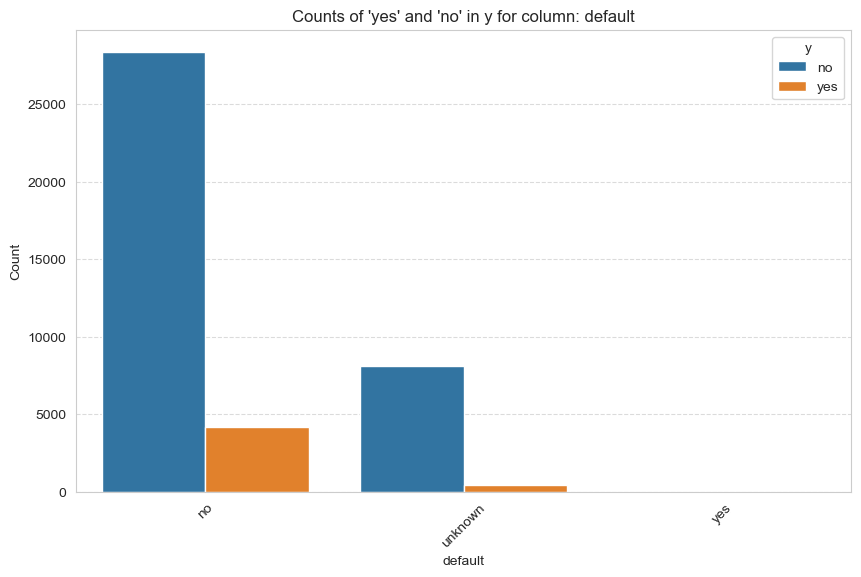

Ratio of 'yes' in default for no: 0.12878973855406897
Ratio of 'yes' in default for unknown: 0.051529603350005816
Ratio of 'yes' in default for yes: 0.0


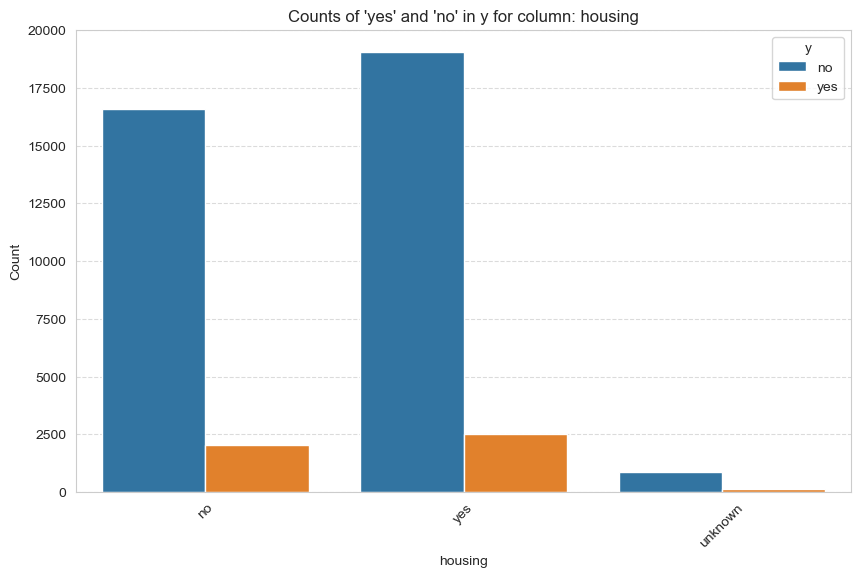

Ratio of 'yes' in housing for no: 0.10879604768553323
Ratio of 'yes' in housing for yes: 0.11619391916944753
Ratio of 'yes' in housing for unknown: 0.10808080808080808


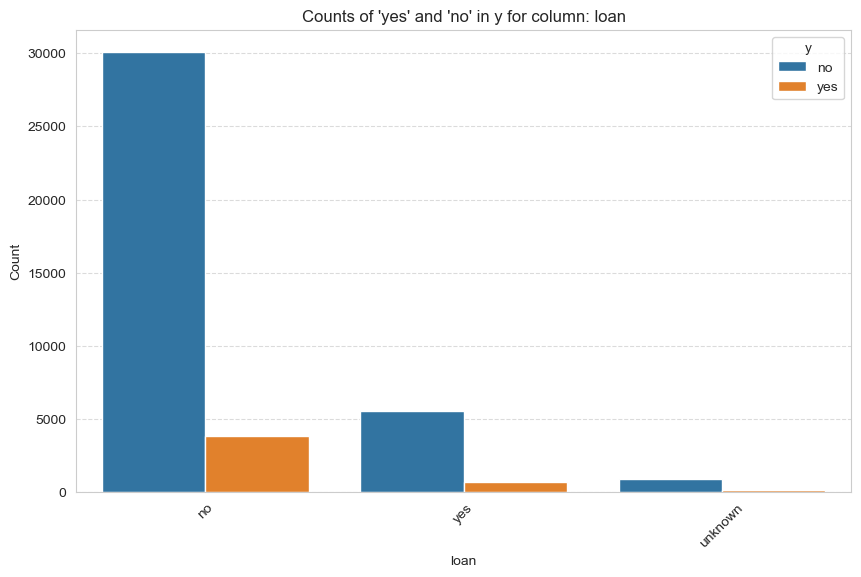

Ratio of 'yes' in loan for no: 0.1134020618556701
Ratio of 'yes' in loan for yes: 0.10931498079385403
Ratio of 'yes' in loan for unknown: 0.10808080808080808


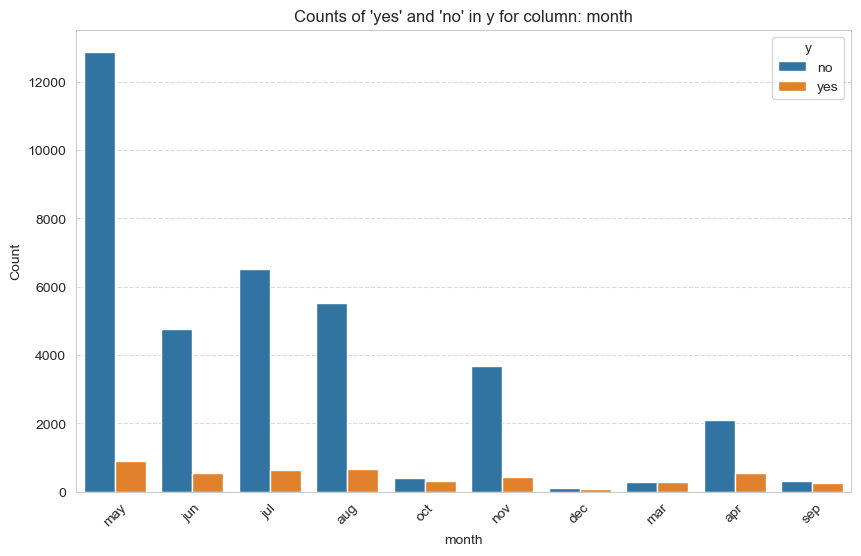

Ratio of 'yes' in month for may: 0.06434744716391895
Ratio of 'yes' in month for jun: 0.10511470477623167
Ratio of 'yes' in month for jul: 0.09046557011430165
Ratio of 'yes' in month for aug: 0.1060213661379087
Ratio of 'yes' in month for oct: 0.4387186629526462
Ratio of 'yes' in month for nov: 0.10143867349426969
Ratio of 'yes' in month for dec: 0.489010989010989
Ratio of 'yes' in month for mar: 0.5054945054945055
Ratio of 'yes' in month for apr: 0.2047872340425532
Ratio of 'yes' in month for sep: 0.44912280701754387


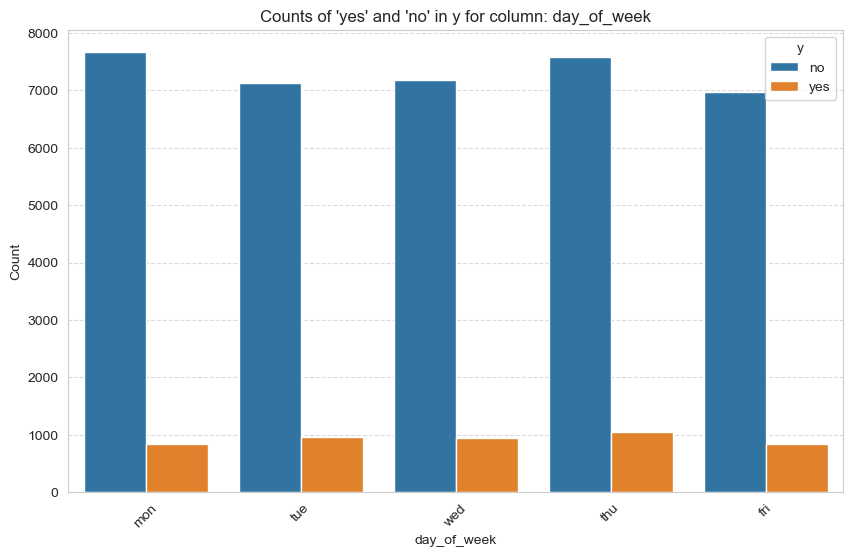

Ratio of 'yes' in day_of_week for mon: 0.09948320413436693
Ratio of 'yes' in day_of_week for tue: 0.11779975278121137
Ratio of 'yes' in day_of_week for wed: 0.11667076469141874
Ratio of 'yes' in day_of_week for thu: 0.12118752174417256
Ratio of 'yes' in day_of_week for fri: 0.1080873898045228


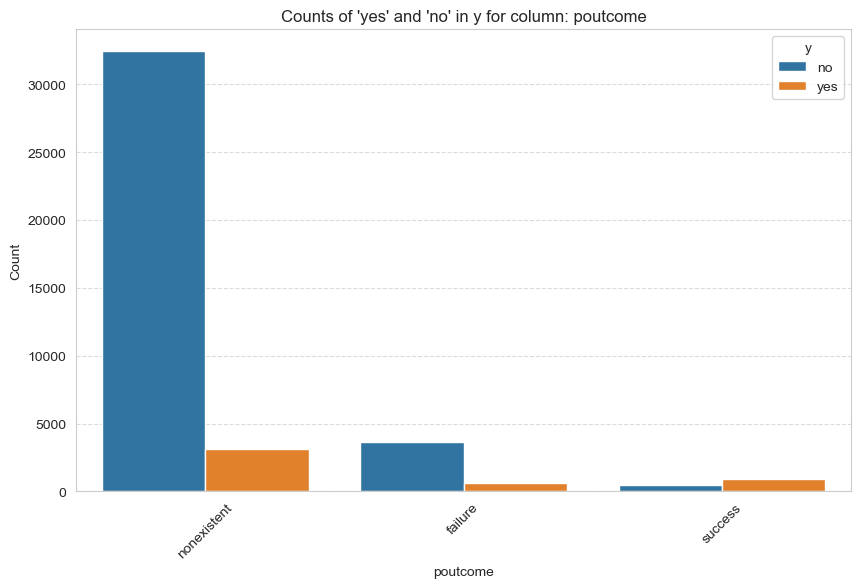

Ratio of 'yes' in poutcome for nonexistent: 0.08832213255349661
Ratio of 'yes' in poutcome for failure: 0.1422859830667921
Ratio of 'yes' in poutcome for success: 0.651128914785142


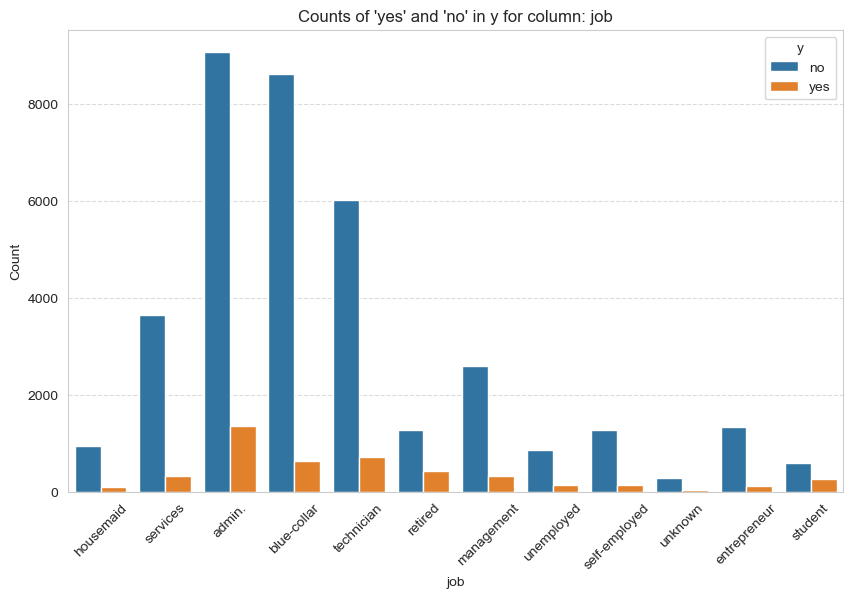

Ratio of 'yes' in job for housemaid: 0.1
Ratio of 'yes' in job for services: 0.08138070042831948
Ratio of 'yes' in job for admin.: 0.12972558050278257
Ratio of 'yes' in job for blue-collar: 0.06894315971471796
Ratio of 'yes' in job for technician: 0.10826041821147857
Ratio of 'yes' in job for retired: 0.25232558139534883
Ratio of 'yes' in job for management: 0.1121751025991792
Ratio of 'yes' in job for unemployed: 0.14201183431952663
Ratio of 'yes' in job for self-employed: 0.10485573539760731
Ratio of 'yes' in job for unknown: 0.11212121212121212
Ratio of 'yes' in job for entrepreneur: 0.08516483516483517
Ratio of 'yes' in job for student: 0.3142857142857143


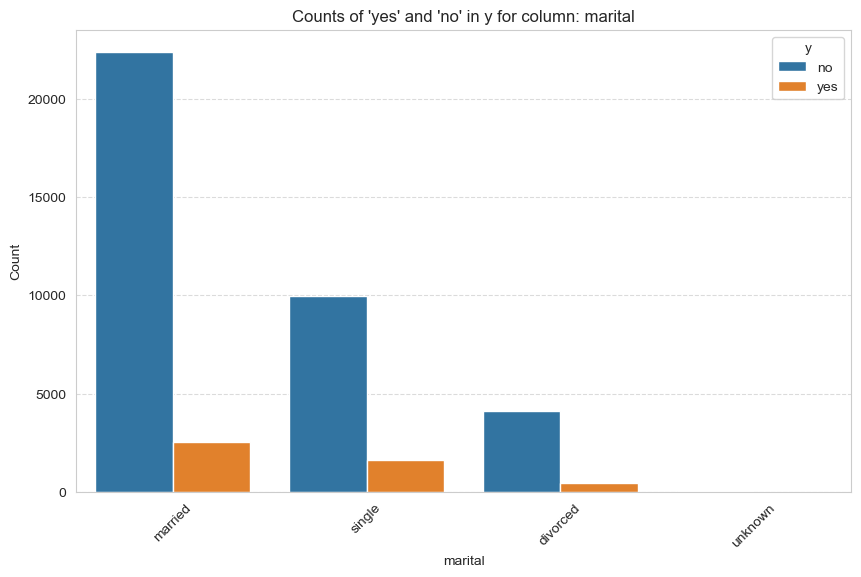

Ratio of 'yes' in marital for married: 0.10157252888318356
Ratio of 'yes' in marital for single: 0.1400414937759336
Ratio of 'yes' in marital for divorced: 0.10320901994796183
Ratio of 'yes' in marital for unknown: 0.15


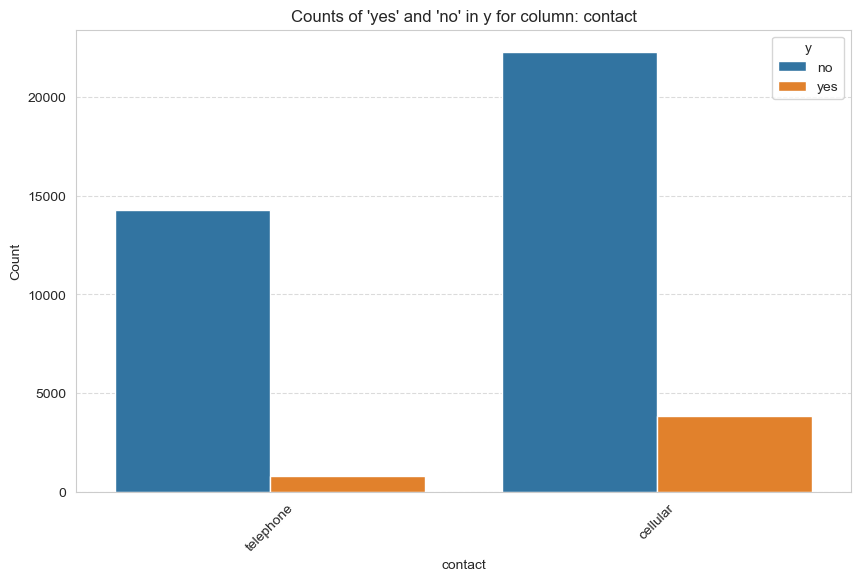

Ratio of 'yes' in contact for telephone: 0.05231321457059293
Ratio of 'yes' in contact for cellular: 0.14737607099143207


In [10]:
# Defining function for categorical exploration
def categoricalExplore(data, col):
    # Plotting counts of "yes" to "no" for each item of a categorical column
    plt.figure(figsize=(10, 6))
    sns.countplot(data, x=col, hue="y")
    plt.title(f"Counts of 'yes' and 'no' in y for column: {col}")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.legend(title="y")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
    
    items = bank_data[col].unique()
    for item in items:
        yes_count = len(bank_data[(bank_data[col] == item) & (bank_data["y"] == "yes")]) # Calculating item-wise "yes" ratios
        print(f"Ratio of 'yes' in {col} for {item}: {yes_count/len(bank_data[(bank_data[col] == item)])}")

# Exploring categorical columns
for col in categorical_attributes:
    categoricalExplore(bank_data, col)

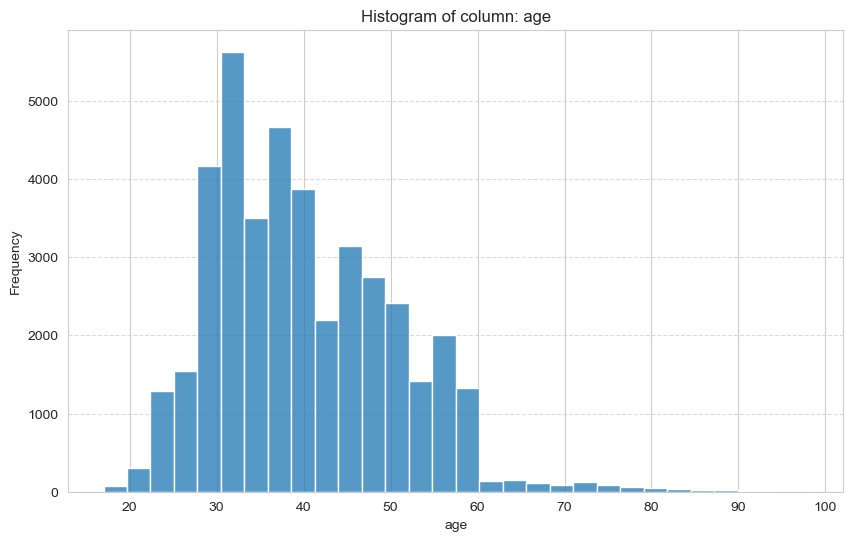

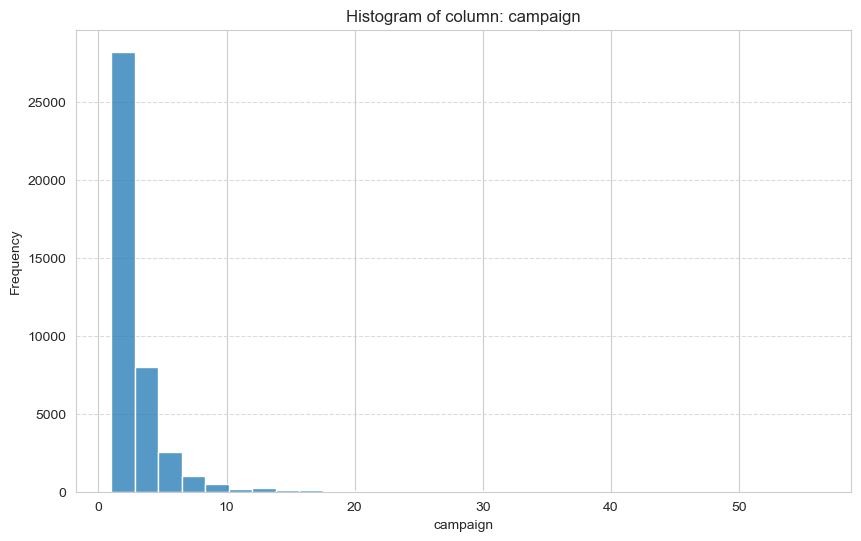

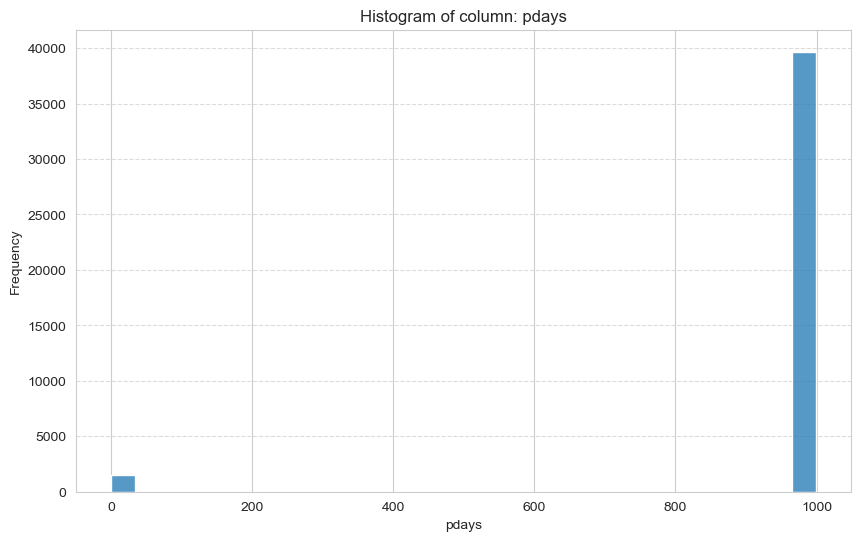

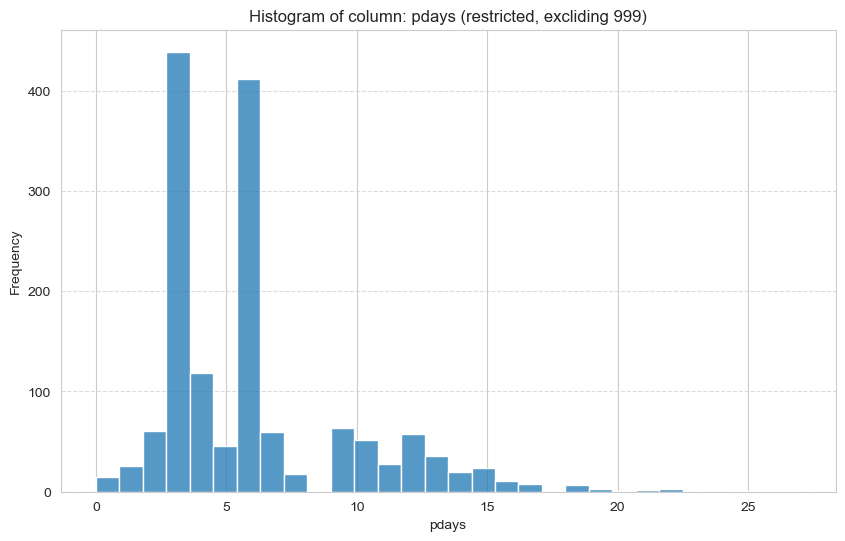

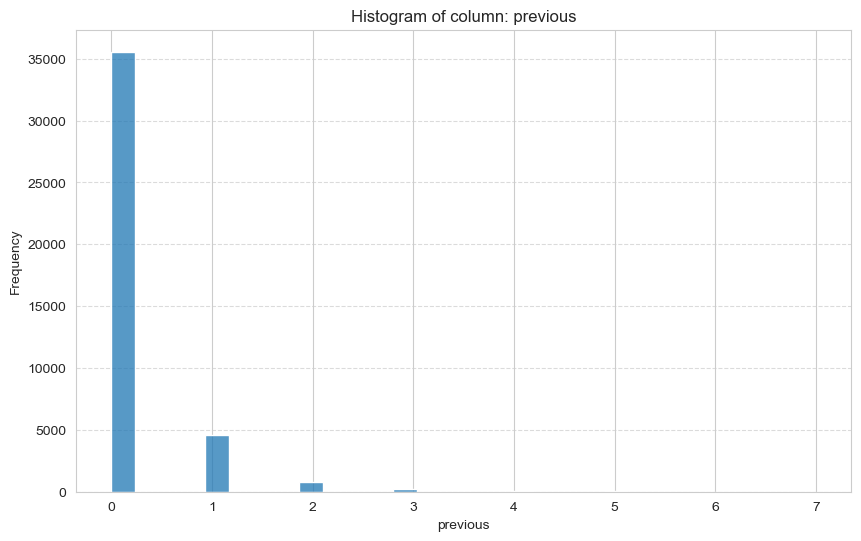

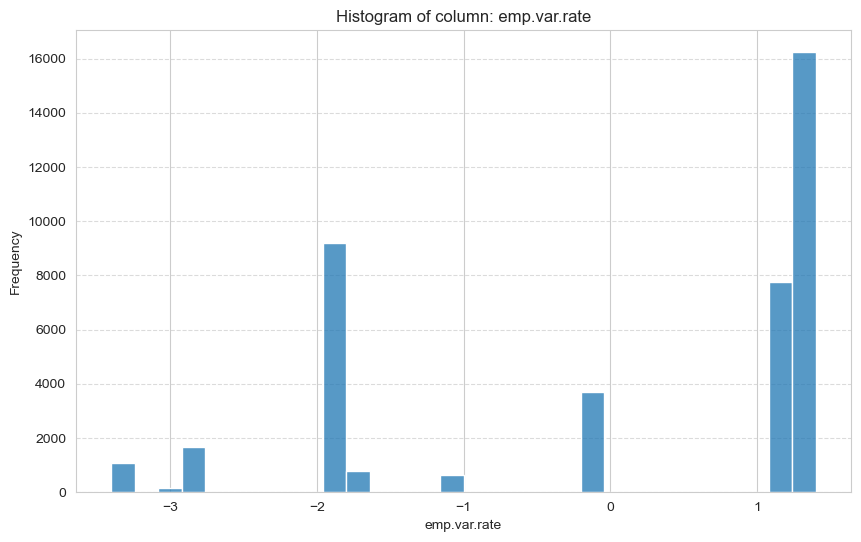

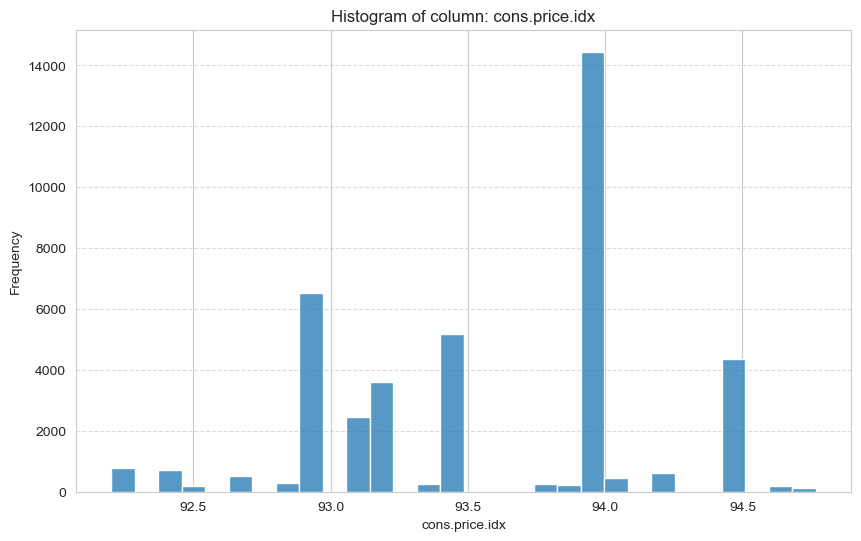

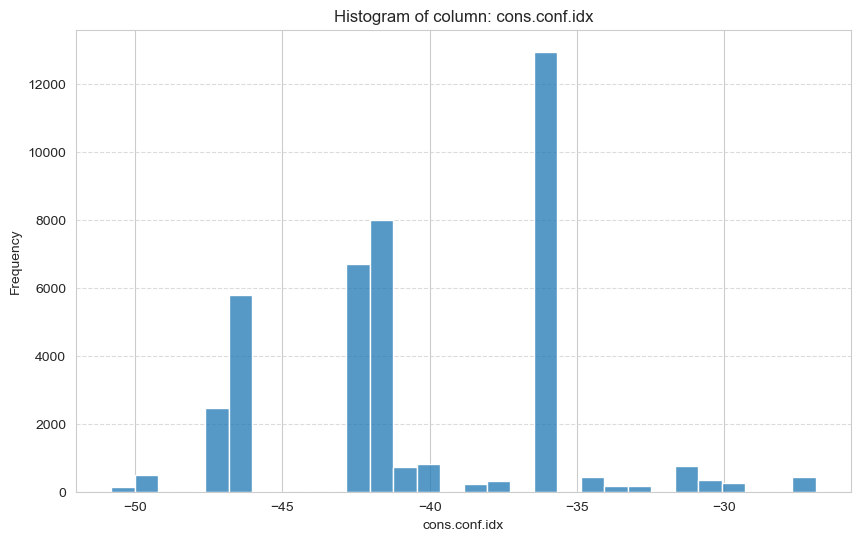

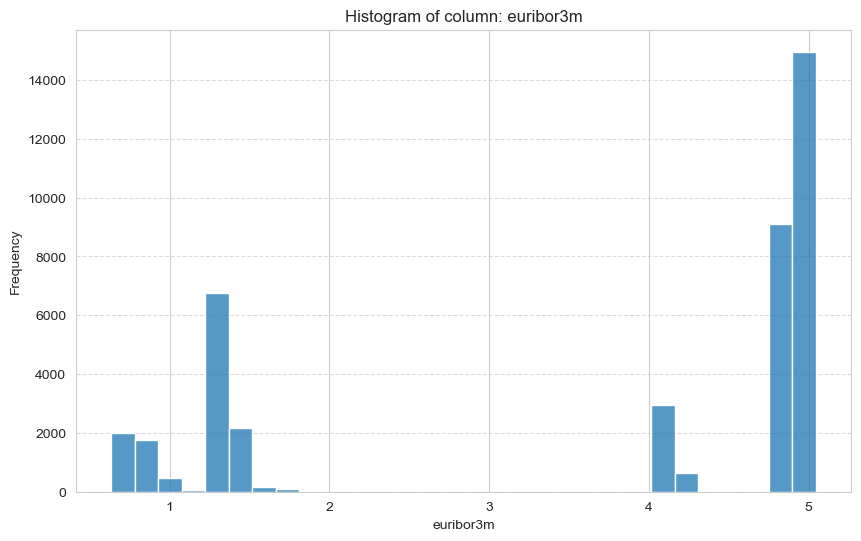

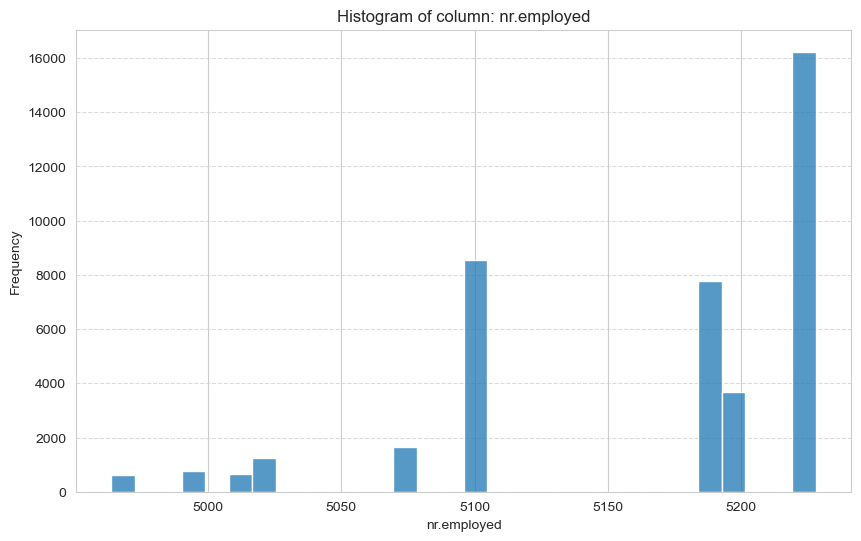

In [11]:
# Defining function for numerical exploration
def numericalExplore(data, col, title):
    # Plotting histogram of numerical column
    plt.figure(figsize=(10, 6))
    sns.histplot(data[col], bins=30)
    plt.title(f"Histogram of column: {title}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Exploring numerical columns
for col in numerical_attributes:
    numericalExplore(bank_data, col, str(col))
    if col == "pdays": # Handling exception on pdays for clearer plotting
        numericalExplore(bank_data[bank_data["pdays"] != 999], col, "pdays (restricted, excliding 999)")

In [12]:
exp_default = bank_data[bank_data["default"] == "yes"]
exp_default.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
21580,48,technician,married,professional.course,yes,no,no,cellular,aug,tue,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
21581,48,technician,married,professional.course,yes,yes,no,cellular,aug,tue,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
24866,31,unemployed,married,high.school,yes,no,no,cellular,nov,tue,2,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8,no


Note 1: For columns which ordinal encoding may be a possibility for, we will discuss the natural order when defining it. For columns which are only highlighted as one-hot, it is assumed that there isn't a specific natural order.

EXPR - Indicates experimentation with removal of that column has been undertaken. If a column has been kept and has this label then the removal of the column made the model perform worse (there were many combinations of removals for experimentation, it was found that keeping these columns was optimal)

age: Keep (Changes: None)
Age is relevant to whether or not someone will make a fixed term savings deposit (FTSD). People in high school are realistically less likely to make a FTSD as opposed to someone who is working full time at a later stage in life, saving for something like a car or house deposit, so age can be a predictive factor.

job: Keep (Changes: Ordinal/ One-hot)
Different jobs earn different salaries. Someone who is unemployed and not earning anything is realistically less likely to make a FTSD than someone working with a stable income. Additionally, those earning more money with a higher paying job may be inclined to save more than those with a lower paying job hence the job someone has can be a predictive factor.

marital: Keep EXPR (Changes: One-hot)
People who are married are at different stages in their lives generally and may be more likely to make a FTSD.

education: Keep (Changes: Ordinal/ One-hot)
Different educational levels may be more likely to make deposits into a FTSD based on the knowledge they have on a topic. Additionally people with a higher educational level may have a higher paying job which as discussed earlier may make that person more likely to make a FTSD.

default: Keep EXPR (Changes: Ordinal/ One-hot)
Our default class is extremely imbalanced with 32588 in the "yes" category and only 3 in the "no" category. It could be sensible to remove this column due to this imbalance, however it is important to note that those who fall into our "no" category have failed to keep up with loan payments (by definition of default). This aspect seems important in determining whether a customer will make a FTSD (since if they cannot keep up with loan payments it is less feasible for them to make a FTSD). Notably, all customers which fall within this category have "no" in our outcome column (y) which backs up our above reasoning. For these reasons we will keep default. Additionally, the removal of this column was experimented with, and it didn't improve the models performances.

housing: Keep (Changes: Ordinal/ One-hot)
Whether someone has a housing loan or not is relevant to if they will make a FTSD.  It can be an indicator of different stages of life as well as financial security.

loan: Keep (Changes: Ordinal/ One-hot)
Could be an indicator of if a customer will make a FTSD. Having a personal loan not being in default could be an indicator of financial security, for example.

contact: Keep EXPR (Changes: One-hot)
This category doesn't seem extremely relevant, but we can keep it for extra information. Perhaps it is an indicator of the generation the client is from - it may be that older people use telephone contact instead of cellular. This could affect our results.

month: Keep (Changes: Ordinal/ One-hot)
Extra information, perhaps people are more likely to make a FTSD depending on the month of the year (e.g. saving for a specific time like a holiday).

day_of_week: Keep (Changes: Ordinal/ One-hot)
Doesn't seem very relevant, but we can keep this anyway as it may have minimal impact and there is no harm in doing so. There may be scenarios where the day of the week is relevant - perhaps Monday is a common payday, and people are more likely to make a FTSD on this day.

campaign: Keep (Changes: StandardScaler)
Number of contacts to the client for this campaign is relevant. More contacts could indicate interest in a FTSD.

pdays: Keep (Changes: 999 occurrences to -1, StandardScaler)
Relevant to our model. Changed 999 to -1 in alignment with txt file and to avoid odd model assumptions.

previous: Keep (Changes: StandardScaler)
Number of contacts to the client for previous campaign is relevant. More contacts could indicate interest in a FTSD.

poutcome: Keep (Changes: StandardScaler)
If there has been success before with this client then that is relevant to whether or not they make a FTSD this time also.

emp.var.rate: Keep (Changes: StandardScaler)
cons.price.idx: Keep (Changes: StandardScaler)
cons.conf.idx: Keep (Changes: StandardScaler)
euribor3m: Keep (Changes: StandardScaler)
nr.employed: Keep (Changes: StandardScaler)
All of these columns have relation to the client - they are all economic indicators which may affect the clients FTSD outcomes.

y: Keep (Changes: map "no" to 0, "yes" to 1)
This is what we are training the model to classify between, so it is necessary.

In [13]:
# Selecting columns for ordinal or one-hot
ordinal_attributes  = ["education", "default", "housing", "loan", "month", "day_of_week", "poutcome"]
onehot_attributes = ["job", "marital", "contact"]

In [14]:
# Defining orders for ordinal columns
education_order = ["illiterate", "unknown", "basic.4y", "basic.6y", "basic.9y", "high.school", "professional.course", "university.degree"] # Based on level of education
default_order = ["yes", "unknown", "no"] # Ordered based on desirability
housing_order = ["no", "unknown", "yes"] # Mortgage likely financially stable
loan_order = ["yes", "unknown", "no"] # General loan maybe slightly less favourable
month_order = ["mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"] # Natural order
day_of_week_order = ["mon", "tue", "wed", "thu", "fri"] # Natural order
poutcome_order = ["nonexistent", "failure", "success"] # Ordered based on desirability

In [15]:
# Feature engineering: previous contact (pdays)
bank_data["pdays"] = bank_data["pdays"].apply(lambda x: -1 if x == 999 else x) # Adjusting pdays for model suitability
bank_data["contacted_before"] = bank_data["pdays"].apply(lambda x: "no" if x == -1 else "yes") # Adding extra column for previous contact

contacted_before_order = ["no", "yes"] # Setting order for ordinal encoding
ordinal_attributes.append("contacted_before")
categorical_attributes.append("contacted_before")

In [16]:
# Feature engineering: financial and job stability (job and age)
job_stability = {
    "management": 5,
    "admin.": 4,
    "technician": 4,
    "entrepreneur": 3,
    "self-employed": 3,
    "retired": 3,
    "blue-collar": 2,
    "services": 2,
    "unknown": 2,
    "housemaid": 1,
    "student": 1,
    "unemployed": 1
}

bank_data["job_stability"] = bank_data["job"].map(job_stability) # Mapping jobs to scores
bank_data["financial_stability"] = bank_data["job_stability"] * bank_data["age"] # Calculating stability score
numerical_attributes.append("job_stability")
numerical_attributes.append("financial_stability")

3 features have been engineered here which may be helpful with model predictions:
1. contacted_before: A more definitive column which may help make predictions (after this column was created pdays was EXPR, but it didn't help the models, keeping both did).
2. job_stability: A score indicating the stability of a job which may help models to make predictions better since this could be a key factor in making a FTSD.
3. financial_stability: A score indicating overall stability in life based off of age and job stability, could be an indicator of maturity which may link with making a FTSD.


In [17]:
# Getting an idea of some correlations within the dataset
correlations = bank_data.corr(numeric_only=True)
correlations

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_stability,financial_stability
age,1.000000,0.004594,0.020467,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.018016,0.567482
campaign,0.004594,1.000000,-0.044047,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,0.005794,0.005159
pdays,0.020467,-0.044047,1.000000,0.506531,-0.229305,-0.047130,0.068703,-0.261907,-0.335027,0.007321,0.021969
previous,0.024365,-0.079141,0.506531,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.002526,0.023470
emp.var.rate,-0.000371,0.150754,-0.229305,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,0.004070,-0.007555
cons.price.idx,0.000857,0.127836,-0.047130,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.059855,-0.050269
cons.conf.idx,0.129372,-0.013733,0.068703,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.062307,0.118737
euribor3m,0.010767,0.135133,-0.261907,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,0.015448,0.008360
nr.employed,-0.017725,0.144095,-0.335027,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,0.018066,-0.006454
job_stability,0.018016,0.005794,0.007321,0.002526,0.004070,-0.059855,0.062307,0.015448,0.018066,1.000000,0.808436


2. **Modelling and Evaluation** - Fitting different models to predict if a customer will make a FTSD, fine-tuning models and evaluating performances

In [18]:
# EXPERIMENTAL AREA - Not used in final model
# Note: these techniques can be used in combination with each other

# Column dropper: used when evaluating model performance after dropping specific columns
# dropper = ["default"] # Defining what to drop
#bank_data = bank_data.drop(columns=dropper) # Dropping

# categorical_attributes = [item for item in categorical_attributes if item not in dropper] # Removing
# column from attributes
#  = [item for item in ordinal_attributes if item not in dropper] # Removing
# column from attributes

# numerical_attributes = [item for item in numerical_attributes if item not in dropper] # Removing column
# from attributes
# print(numerical_attributes)

# -----------

# Row dropper: used when evaluating model performance after dropping rows containing "unknown"
# bank_data = bank_data[~bank_data.isin(["unknown"]).any(axis=1)] # Dropping rows containing "unknown"
# bank_data = bank_data.reset_index(drop=True) # Needed for indexing in next cell

# -----------

# Row imputation: used when evaluating model performance after changing "unknown" to the most common occurrence
# for col in categorical_attributes:
#     mode_value = bank_data[col].mode()[0]  # Get most frequent value
#     bank_data.loc[bank_data[col] == "unknown", col] = mode_value  # Use .loc to modify in-place

# -----------

# Again row imputation, but by setting "unknown" to nan and imputing inside the pipeline instead (not used)
# bank_data.replace("unknown", np.nan, inplace=True)

The experimental area is where everything which was not included in the final model is kept. Many different combinations of these were used together to try to optimise the model, however it was found in the end that just keeping the standard columns (without duration and after tweaking pdays) alongside the engineered features yielded the best model performance.

Some notable experiments:
1. Removing default
2. Removing all unknown rows
3. Removing default, then the rest of the rows containing "unknown"
4. Imputing "unknown values" with the most common item in the column (2 methods for this - pipeline and non-pipeline)

Additionally, encoding using ordinal alongside one-hot was flicked on and off for testing with some of these modules. Currently ordinal encoding alongside one-hot is still usable and the tweaks above are too if un-hashed, but if we want to use, for example, the column dropper alongside ordinal and one-hot encoding, then we would need to go into the pipeline and hash out the orders in ordinal_encoder (i.e. if we removed default then we need #default_order,).

Here are some results from cross-validation scores on the non-fine-tuned models. Note when we are discussing scores after fine-tuning we are discussing how it performs on the test set (this does not cause bias but for extra certainty the kernel was restarted after every test regardless).

Ordinal w/ One-hot Encoding: A

One-hot Encoding: B

A.

1. SVM Cross-Val F1 Score: 0.5622 ± 0.1583 (worse than B)
2. Logistic Regression Cross-Val F1 Score: 0.6375 ± 0.0053 (worse than B)
3. Random Forest Cross-Val F1 Score: 0.6523 ± 0.0047 (this is slightly better than A, but after fine-tuning we achieve 0.73 for both macro avg f1-scores on the test set)

B (Chosen model).

1. SVM Cross-Val F1 Score: 0.6766 ± 0.0089
2. Logistic Regression Cross-Val F1 Score: 0.6732 ± 0.0069
3. Random Forest Cross-Val F1 Score: 0.6487 ± 0.0072

A1.

1. SVM Cross-Val F1 Score: 0.5863 ± 0.0672 (worse than B)
2. Logistic Regression Cross-Val F1 Score: 0.6343 ± 0.0055 (worse than B)
3. Random Forest Cross-Val F1 Score: 0.6479 ± 0.0053 (worse than B)

B1.

1. SVM Cross-Val F1 Score: 0.6779 ± 0.0078 (slightly better than B, almost identical to B when fine-tuned)
2. Logistic Regression Cross-Val F1 Score: 0.6736 ± 0.0070 (slightly better than B, worse than B when fine-tuned)
3. Random Forest Cross-Val F1 Score: 0.6502 ± 0.0070 (slightly better than B, almost identical to B when fine-tuned)

B3.

1. SVM Cross-Val F1 Score: 0.6839 ± 0.0054 (a bit better than B, worse than B when fine-tuned)
2. Logistic Regression Cross-Val F1 Score: 0.6805 ± 0.0062 (a bit better than B, worse than B when fine-tuned)
3. Random Forest Cross-Val F1 Score: 0.6622 ± 0.0044 (a bit better than B, worse than B when fine-tuned)

Based on these results (and others which are not presented here but accounted for) we will follow through with the use of model B. We have chosen this model due to it performing better after fine-tuning on the test set and also due to the fact that it preserves unknown data, which allows us to achieve a more realistic model (which is likely why it performed better in the end).

In [19]:
# Defining parameters for stratified shuffle split
shuffled_data = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.15,
    random_state=42
)

# Converting y to numerical (1 and 0 instead of "yes" and "no")
if bank_data["y"].dtype == "object":
    bank_data["y"] = bank_data["y"].map({"no": 0, "yes": 1}).astype(int)

# Performing stratified shuffle split
[(train_index, test_index)] = shuffled_data.split(bank_data, bank_data["y"])

# Setting train and test set based on index lists
bank_data_train = bank_data.loc[train_index]
bank_data_test = bank_data.loc[test_index]

Here we explicitly define whether to use ordinal encoding with one-hot, or just one-hot with the method variable. Method 2 is preferable for model performance.

In [20]:
# Setting method (1. ordinal with one-hot encoding, 2. one-hot encoding)
method = 2 # This is the preferred method which performs the best as discussed

X_train = bank_data_train.drop("y", axis=1) # Dropping outcome column from features train set
y_train = bank_data_train["y"] # Setting train label set

X_test = bank_data_test.drop("y", axis=1) # Dropping outcome column from features test set
y_test = bank_data_test["y"] # Setting test label set

# Setting the orders (defined earlier) for ordinal encoding
ordinal_encoder = OrdinalEncoder(categories=[
    education_order,
    default_order,
    housing_order,
    loan_order,
    month_order,
    day_of_week_order,
    poutcome_order,
    contacted_before_order
])

# Defining imputer for replacing NaN with most frequent value
# imputer = SimpleImputer(strategy="most_frequent") # Unused

# Defining pipeline for one-hot encoding
onehot_pipeline = Pipeline(steps=[
#   ("imputer", imputer), # Imputing (unused)
    ("onehot", OneHotEncoder()) # One-hot encoding
])

# Defining pipeline for ordinal encoding, not used if method = 2
ordinal_pipeline = Pipeline(steps=[
#   ("imputer", imputer), # Imputing (unused)
    ("ordinal", ordinal_encoder) # Ordinal encoding
])

# Defining pipeline for numerical scaling
numerical_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()) # Scaling
])

# Setting which transformations to use based on the defined method
if method == 1:
    transformers = [
        ("cat-ordinal", ordinal_pipeline, ordinal_attributes),
        ("cat-onehot", onehot_pipeline, onehot_attributes),
        ("numerical", numerical_pipeline, numerical_attributes)
    ]
elif method == 2:
    transformers = [
        ("cat-onehot", onehot_pipeline, categorical_attributes),
        ("numerical", numerical_pipeline, numerical_attributes)
    ]

# Defining the full pipeline for calling with ColumnTransformer
full_pipeline = ColumnTransformer(transformers=transformers)

X_train_prepared = full_pipeline.fit_transform(X_train) # Applying pipeline to prepare train test
X_test_prepared = full_pipeline.transform(X_test) # Applying pipeline to prepare test set
# No changes need to be made to either of our y (label) sets

In [21]:
# For all classifiers:
# Using class_weight={0: weights[0], 1: weights[1]} since our dataset is imbalanced.
# Have experimented with nothing and also "balanced" class weights and this is what
# yielded the best results. Also set random_state to 42 for reproducibility.

names = ["SVM", "Logistic Regression", "Random Forest"]
weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def score(model, name, X_train, y_train, cv_strategy):
    scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring="f1_macro")
    print(f"{name} Cross-Val F1 Score: {scores.mean():.4f} ± {scores.std():.4f}")

# 1. SVM Classifier 
svm = SGDClassifier(random_state=42, class_weight={0: weights[0], 1: weights[1]}) # Calling model
score(svm, names[0], X_train_prepared, y_train, cv_strategy)

# 2. Logistic Regression
logistic_regression = LogisticRegression(random_state=42, class_weight={0: weights[0], 1: weights[1]}) # Calling model
score(logistic_regression, names[1], X_train_prepared, y_train, cv_strategy)

# 3. Random Forest Classifier
random_forest = RandomForestClassifier(random_state=42, class_weight={0: weights[0], 1: weights[1]}) # Calling model
score(random_forest, names[2], X_train_prepared, y_train, cv_strategy)

models = [[svm, names[0]], [logistic_regression, names[1]], [random_forest, names[2]]]

SVM Cross-Val F1 Score: 0.6766 ± 0.0089
Logistic Regression Cross-Val F1 Score: 0.6732 ± 0.0069
Random Forest Cross-Val F1 Score: 0.6487 ± 0.0072


In [22]:
# Defining function for fine-tuning a model
def fineTune(model, param_grid, name, X_train, y_train, cv_strategy):
    print(f"Fine-tuning {name}:")

    # Setting up grid search with inputted parameter grid and strategy
    grid_search = GridSearchCV(
        model, param_grid,
        cv=cv_strategy,
        scoring="f1_macro",
        n_jobs=-1, verbose=1
    )

    grid_search.fit(X_train, y_train)  # Proceeding with grid search

    # Setting best model, parameters and score
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Displaying information on best parameters and score
    print(f"Best parameters for {name}: {best_params}")
    print(f"Cross-Validation Score for {name}: {best_score}")

    return best_model  # Returning the best model

# Setting parameter grids for chosen models
param_grid_svm = {
    "alpha": [1e-4, 1e-3, 1e-2], # Learning rate
    "penalty": ["l2", "l1"], # Regularisation
    "max_iter": [500, 1000, 5000] # Max iterations
}

param_grid_lr = {
    "C": [10, 100, 250, 500], # Regularisation strength
    "solver": ["liblinear", "lbfgs"], # Optimisation algorithms
    "max_iter": [100, 500, 1000]  # Max iterations
}

param_grid_rf = {
    "n_estimators": [50, 100, 300], # No. of trees
    "max_depth": [10, 20, 30], # Max depth of trees
    "min_samples_split": [2, 5, 10], # Min samples to split internal node
    "min_samples_leaf": [2, 4], # Min samples at leaf node
    "bootstrap": [True, False] # Bootstrapping
}

# Saving parameter grids to list and initialising empty dict for tuned models
param_grid = [param_grid_svm, param_grid_lr, param_grid_rf]
tuned_models = {}

start = 0
end = 3

# Going through each model to find optimal parameters
for i in range(start, end):
    tuned_models[models[i][1]] = fineTune(models[i][0], param_grid[i], models[i][1], X_train_prepared, y_train, cv_strategy)

Fine-tuning SVM:
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for SVM: {'alpha': 0.001, 'max_iter': 500, 'penalty': 'l1'}
Cross-Validation Score for SVM: 0.6772104727388549
Fine-tuning Logistic Regression:
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for Logistic Regression: {'C': 500, 'max_iter': 100, 'solver': 'lbfgs'}
Cross-Validation Score for Logistic Regression: 0.6735120715515208
Fine-tuning Random Forest:
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Random Forest: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Cross-Validation Score for Random Forest: 0.7128235515722685


In [23]:
# Defining function for plotting ROC and Precision-Recall curves
def plot_roc_pr_curves(model, name, X_test, y_test):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    if name == "SVM Optimised":
        y_scores = model.decision_function(X_test)  # decision_function for SVM to work
    else:
        y_scores = model.predict_proba(X_test)[:, 1]  # predict_proba for LR and RF to work

    # Setting ROC Curve
    FPR, TPR, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(FPR, TPR)
    ax[0].plot(FPR, TPR, label=f"AUC = {roc_auc:.4f}")
    ax[0].plot([0, 1], [0, 1], "k--", label="Random Guess")
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[0].set_title(f"ROC Curve - {name}")
    ax[0].legend()

    # Setting Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)
    ax[1].plot(recall, precision, label=f"AUC = {pr_auc:.4f}")
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].set_title(f"Precision-Recall Curve - {name}")
    ax[1].legend()

    plt.show() # Plotting

# Defining function for plotting Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, name):
    conf = confusion_matrix(y_true, y_pred) # Getting confusion matrix
    conf_norm = conf / conf.sum(axis=1, keepdims=True)  # Normalizing per row

    # Plotting Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_norm, annot=True, cmap="Blues", xticklabels=["no", "yes"], yticklabels=["no", "yes"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

Final Performance on Test Set (SVM):
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      5483
           1       0.37      0.62      0.47       696

    accuracy                           0.84      6179
   macro avg       0.66      0.74      0.69      6179
weighted avg       0.88      0.84      0.86      6179



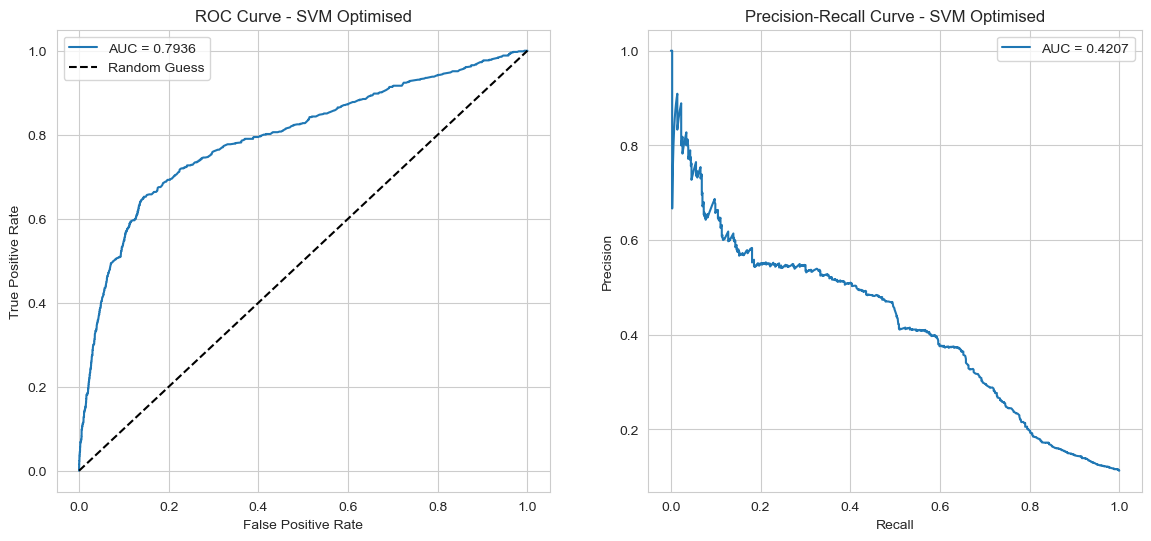

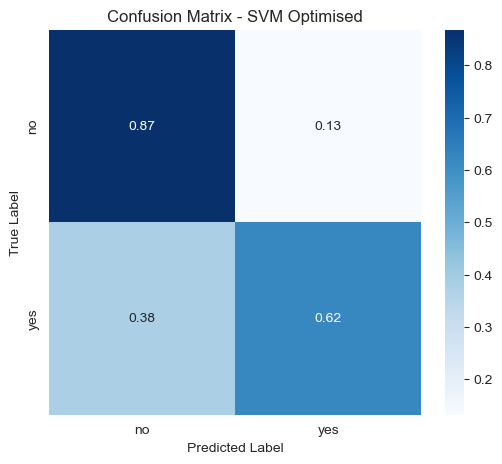

Final Performance on Test Set (Logistic Regression):
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      5483
           1       0.37      0.65      0.47       696

    accuracy                           0.84      6179
   macro avg       0.66      0.76      0.69      6179
weighted avg       0.89      0.84      0.85      6179



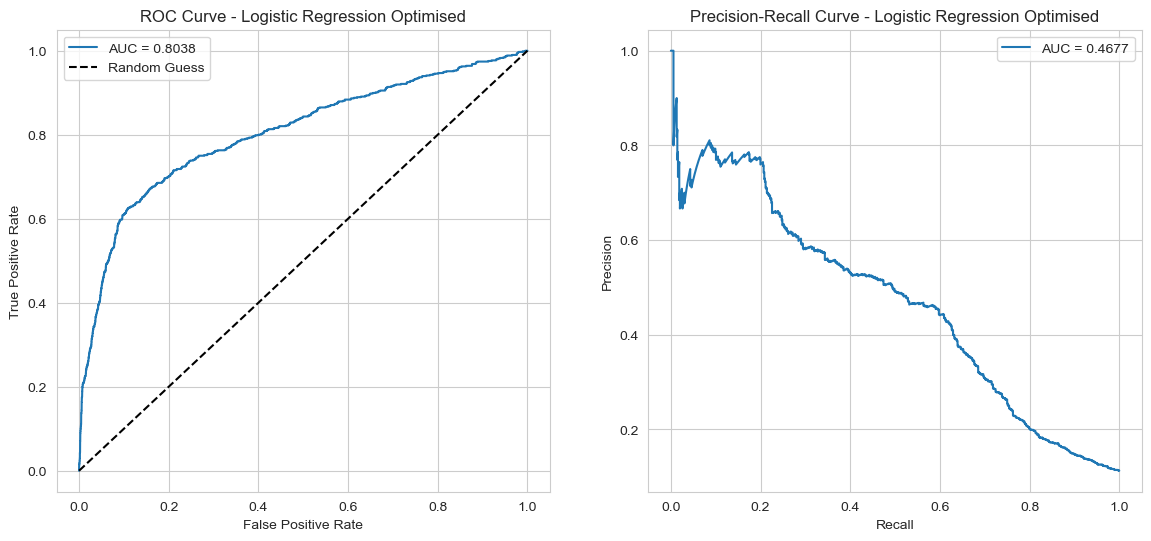

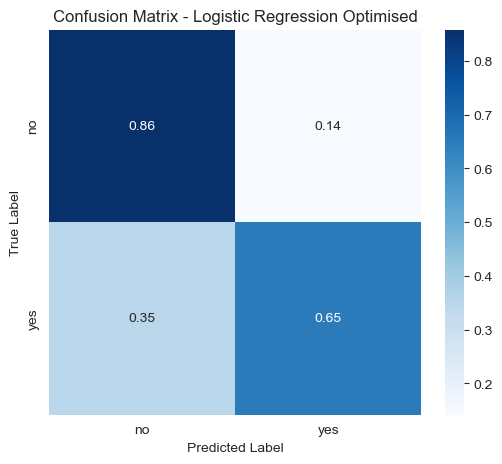

Final Performance on Test Set (Random Forest):
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      5483
           1       0.50      0.57      0.53       696

    accuracy                           0.89      6179
   macro avg       0.72      0.75      0.73      6179
weighted avg       0.89      0.89      0.89      6179



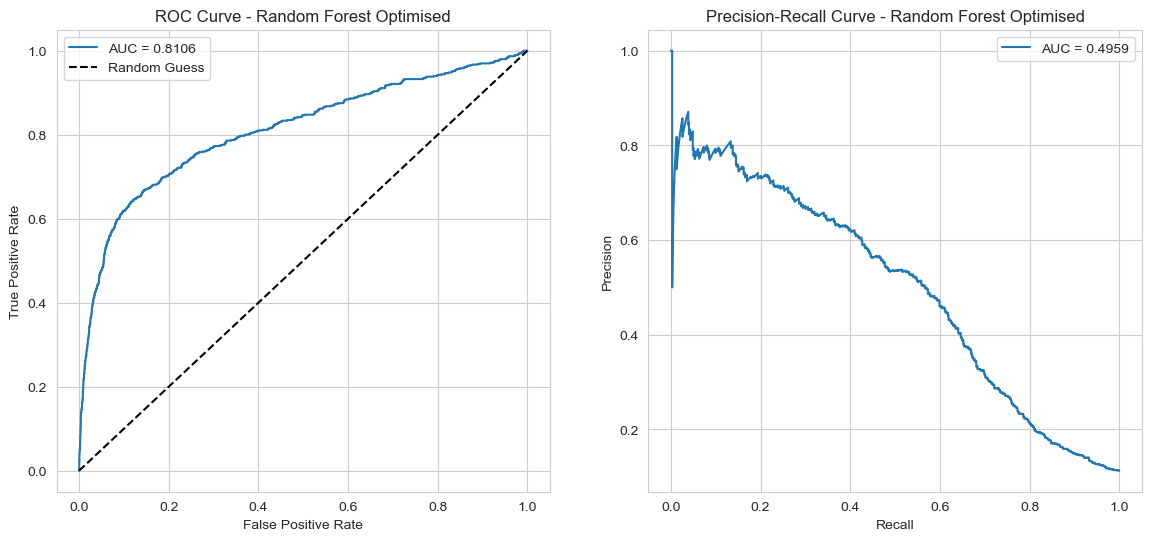

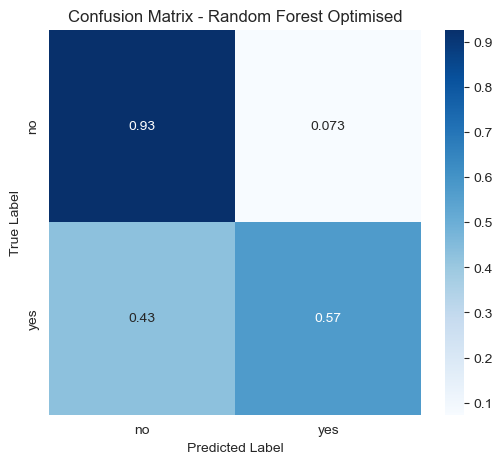

In [24]:
# Evaluating fine-tuned models on unseen test set
for i in range(start, end):
    y_pred = tuned_models[models[i][1]].predict(X_test_prepared)
    print(f"Final Performance on Test Set ({models[i][1]}):")
    print(classification_report(y_test, y_pred)) # Displaying classification report
    plot_roc_pr_curves(tuned_models[models[i][1]], models[i][1] + " Optimised", X_test_prepared, y_test) # Plotting ROC and Precision-Recall curves
    plot_confusion_matrix(y_test, y_pred, models[i][1] + " Optimised") # Plotting Confusion Matrix

Based on our performance measures we can see that our Random Forest Classifier is performing the best. We have achieved a reasonable score on all 3 models given the large data imbalance. It may be most sensible if there is a lack of computational power to use the Logistic Regression or SVM Classifier, which also performs decently, since training and fine-tuning the Random Forest model took some time to run.